In [5]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import VAE
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [6]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [7]:
def pairwise_distances(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y = x
    y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist 

In [8]:
def loss(recon_atac, recon_rna, atac, rna, z, diff_distance, lamb):
    loss = F.mse_loss(rna, recon_rna) + F.mse_loss(atac, recon_atac) + lamb * F.mse_loss(diff_distance.reshape(-1), pairwise_distances(x).reshape(-1))
    return loss

In [12]:
class scDataset(Dataset):

    def __init__(self, atac_seq_file = "./data/expr_atac_processed.csv", rna_seq_file = "./data/expr_rna_processed.csv", standardize = False):
        self.expr_ATAC = pd.read_csv(atac_seq_file, index_col=0).to_numpy()
        self.expr_RNA = pd.read_csv(rna_seq_file, index_col=0).to_numpy()
        # standardize
        if standardize:
            self.expr_ATAC = StandardScaler().fit_transform(self.expr_ATAC)
            self.expr_RNA = StandardScaler().fit_transform(self.expr_RNA)

        # self.transform = transform
    
    def __len__(self):
        # number of cells
        return len(self.expr_ATAC)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'ATAC': self.expr_ATAC[idx,:], 'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        # if self.transform:
        #     sample = self.transform(sample)
        
        return sample

# # transform
# class standardize(object):

#     def __call__(self, sample):
#         sample_ATAC = StandardScaler().fit_transform(sample['ATAC'][None,:])
#         sample_RNA = StandardScaler().fit_transform(sample['RNA'][None,:])
#         return {'ATAC': torch.from_numpy(sample_ATAC.squeeze()), 'RNA':torch.from_numpy(sample_RNA.squeeze())}

In [13]:
sc_dataset = scDataset(standardize = True)
data_loader = DataLoader(sc_dataset, batch_size=4, shuffle=True, num_workers=0)

In [14]:
for idx, data in enumerate(data_loader):
    data
    break

In [15]:
data['RNA'].shape

torch.Size([4, 1185])

In [16]:
data

{'ATAC': tensor([[-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634],
         [-0.0412, -0.0582, -0.0491,  ..., -0.0845, -0.0458, -0.0634]],
        dtype=torch.float64),
 'RNA': tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
         [-0.2093,  4.0936,  2.0138,  ..., -0.3284, -0.5554, -0.3166],
         [-0.2093, -0.4197,  0.5750,  ..., -0.3284,  0.5759,  2.1366],
         [-0.2093, -0.4197,  1.5590,  ..., -0.3284,  1.8069, -0.3166]],
        dtype=torch.float64),
 'index': tensor([ 528, 2110, 1511, 1215])}

## Diffusion distance

In [85]:
import numpy as np
from sklearn import datasets
import diffusion_dist as diff
import matplotlib.pyplot as plt
N = 1000
X, color = datasets.make_s_curve(N, random_state=1)

In [86]:
diffu = diff.diffusion_map(X, n_eign = 10, alpha = 0.05, diffusion_time = 5)
diff_sim = diff.diffusion_similarity(diffu)

**First two dimensions of the diffusion distance**

(9441,)

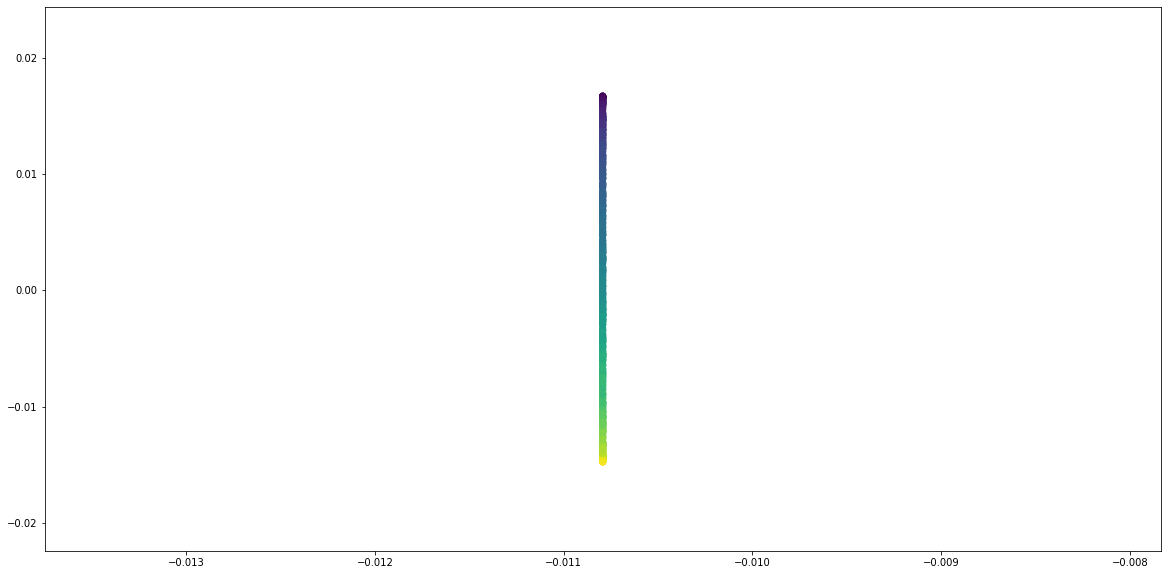

In [87]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,0], diffu[:,1], c = color)

**Original distance**

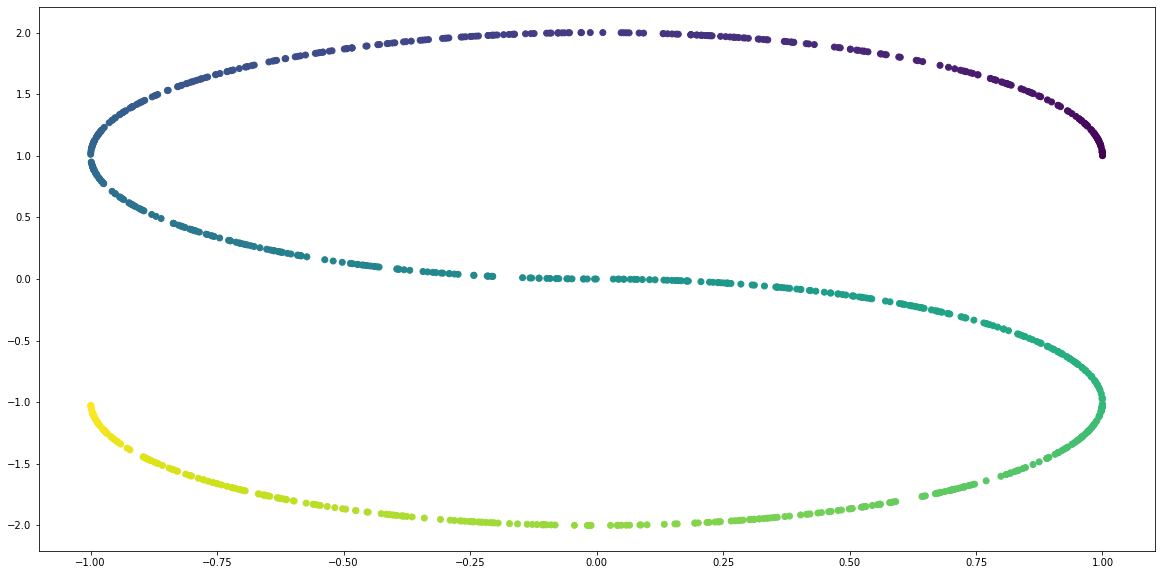

In [34]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(X[:,0], X[:,2], c= color)

**Diffusion distance similarity matrix**

In [9]:
diff_sim.shape

(1000, 1000)

In [65]:
def latent_semantic_indexing(doc_matrix, k):
    """\
        Compute LSI, i.e. SVD on document matrix

        Parameters:
            doc_matrix: term by document count matrix
        Returns:
            latent: document latent matrix
    """
    doc_matrix = doc_matrix.T
    count = np.count_nonzero(doc_matrix, axis=1)
    count = np.log(doc_matrix.shape[1] / count)
    doc_matrix = doc_matrix * count[:,None]

    from scipy.linalg import svd
    U, S, Vh = svd(doc_matrix, full_matrices = False, compute_uv = True)
    latent = np.matmul(Vh[:k, :].T, np.diag(S[:k]))
    return latent

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
# atac_latent = latent_semantic_indexing(atac, 1000)
atac_latent = pca.fit_transform(atac)

In [101]:
diffu = diff.diffusion_map(atac_latent, n_eign = 10, alpha = 0.01, diffusion_time = 5)
diff_sim = diff.diffusion_similarity(diffu)

In [99]:
atac_latent

array([[-0.09167055, -0.50309515,  0.08422477, ..., -0.2504387 ,
        -0.26349554, -0.25788488],
       [-0.71469943, -0.20407945, -0.48073878, ..., -1.11665003,
        -0.08295662,  0.17510815],
       [-1.42422505, -0.19379886,  0.62033844, ...,  0.08068005,
         0.24778338, -0.14001687],
       ...,
       [ 2.24876208,  1.2445471 ,  0.3464068 , ...,  0.64481396,
         0.15910925,  0.06536264],
       [-0.05787008, -0.31665423, -0.66194493, ...,  0.31682468,
        -0.16766917,  0.0131038 ],
       [-1.54981137, -0.01823881,  0.08893158, ..., -0.03275307,
         0.10265593,  0.04891975]])

In [102]:
np.unique(diffu)

array([0., 1.])

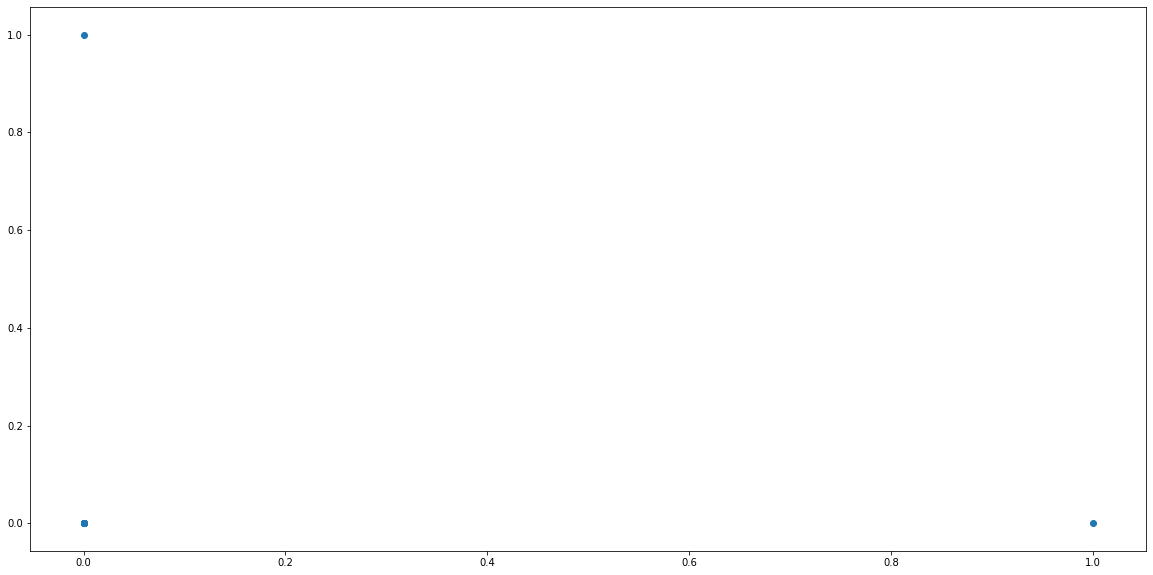

In [80]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2])